# 1. Libraries

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import shutil
import cv2
import os
from tqdm import tqdm,tqdm_notebook
from PIL import Image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D ,GlobalAveragePooling2D,Flatten,Activation,MaxPooling2D,Dropout,BatchNormalization


In [ ]:
#Unzipping the file
shutil.unpack_archive("Data.zip")

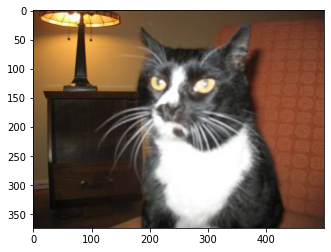

In [ ]:
#Viewing the image
from PIL import Image
im = Image.open('/content/Data/Train/Cats/10002.jpg')
plt.imshow(im)
plt.show()

# 2. Loading Data

In [ ]:
#Need all the files in one directory, so Combining CAT and Dog images in Dog folder.
for file in tqdm(os.listdir('/content/Data/Train/Cats')):
  shutil.move('/content/Data/Train/Cats/'+file, '/content/Data/Train/Dogs/')
  

100%|██████████| 4747/4747 [00:00<00:00, 20685.66it/s]


In [ ]:
#loading Train.csv as dataframe. It consists immage name and class label.
train_data_df=pd.read_csv('/content/Data/Train.csv')
train_data_df['Category'] = train_data_df['Category'].apply(str) #for the purpose of image generator.
print(train_data_df.shape)
train_data_df.head()

(9471, 2)


,File_Name,Category
0,10846.jpg,1
1,2360.jpg,1
2,17531.jpg,0
3,13254.jpg,1
4,15554.jpg,0


# 3.Model

In [122]:
# Image Generators, with data agumentation.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1/255., width_shift_range=0.12, height_shift_range=0.12, horizontal_flip=True, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(dataframe=train_data_df, directory='/content/Data/Train/Dogs/',x_col='File_Name',y_col='Category',target_size=(224,224),class_mode='binary',batch_size=64,subset='training',seed=7)
validation_generator = datagen.flow_from_dataframe(dataframe=train_data_df, directory='/content/Data/Train/Dogs/',x_col='File_Name',y_col='Category',target_size=(224,224),class_mode='binary',batch_size=64,subset='validation',seed=7)

Found 7577 validated image filenames belonging to 2 classes.
Found 1894 validated image filenames belonging to 2 classes.


In [92]:
#Creating new directory to move all the test images, a new directory needs to be created for test image generator. 
mkdir total_test_img 
for file in os.listdir('/content/Data/Test/'):
  shutil.move(file,'/content/Data/Test/total_test_img/')

In [123]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D ,GlobalAveragePooling2D,Flatten,Activation,MaxPooling2D,Dropout,BatchNormalization

#loading basemodel
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

# mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable = False

flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(1, activation='sigmoid')(class1)

# define new base_model
model_1 = Model(inputs=base_model.inputs, outputs=output)


In [117]:
model_1.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
#not required, Just used for experiment with out vgg16 pretrained model.
from tensorflow.keras import Sequential
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='sigmoid'))

In [131]:
#call back to stop the model if validation_acc >98.5%
from keras.callbacks import Callback
TEST_ACCURACY_THRESHOLD = 0.985
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > TEST_ACCURACY_THRESHOLD):
      print("\nReached %2.2f%% accuracy, so stopping training!!" %(TEST_ACCURACY_THRESHOLD*100))
      self.model.stop_training = True
early_stop = myCallback()

In [137]:
# compiling and fitting the model.
opt = SGD(lr=0.001, momentum=0.9)
model_1.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
model_1.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=50,validation_data=validation_generator,validation_steps=validation_steps,callbacks=[early_stop])

Epoch 1/50
118/118 [==============================] - 144s 1s/step - loss: 0.0091 - accuracy: 0.9972 - val_loss: 0.0427 - val_accuracy: 0.9838
Epoch 2/50
118/118 [==============================] - 143s 1s/step - loss: 0.0156 - accuracy: 0.9953 - val_loss: 0.0453 - val_accuracy: 0.9838
Epoch 3/50
118/118 [==============================] - 142s 1s/step - loss: 0.0094 - accuracy: 0.9971 - val_loss: 0.0602 - val_accuracy: 0.9811
Epoch 4/50
118/118 [==============================] - 143s 1s/step - loss: 0.0079 - accuracy: 0.9971 - val_loss: 0.0562 - val_accuracy: 0.9828
Epoch 5/50
118/118 [==============================] - 144s 1s/step - loss: 0.0088 - accuracy: 0.9979 - val_loss: 0.0579 - val_accuracy: 0.9806
Epoch 6/50
118/118 [==============================] - 144s 1s/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.0490 - val_accuracy: 0.9838
Epoch 7/50
118/118 [==============================] - 143s 1s/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0480 - val_accuracy: 0.9828

KeyboardInterrupt: ignored

# 4. Prediction on Test Data

In [134]:
# prediction on test data using predict_generator.
test_dir='/content/Data/Test/'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(224, 224),color_mode="rgb",shuffle = False,class_mode='binary',batch_size=32)     
filenames = test_generator.filenames
nb_samples = len(filenames)
print(nb_samples)


#making predictions
predict = model_1.predict_generator(test_generator,steps = np.ceil(nb_samples/32))

#fetchig the image names
File_Name=[]
for i in filenames:
  File_Name.append(i.split('/')[-1])
test_class_labels=[]

#rounding to pre to class labels 1 and 0
for i in predict:
  if i<0.5:
    test_class_labels.append(0)
  else:
    test_class_labels.append(1)

#creating test dataframe, with file name and predicted class labels
Test=pd.DataFrame({'File_Name':File_Name,'Category':test_class_labels})

#Storing Test in .csv format.
Test.to_csv('/content/Test.csv')

Found 4059 images belonging to 1 classes.
4059
